In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

# Closed Loop implemented as Neural ODE on a mesh

## Past models of myosin dynamics

Increasing sparsity:

    D_t m_ij  = 1.431 m_ij Tr(E_passive)
    D_t m_ij = 0.305 * Tr(m) * m_ij - 0.160 * {m, E}
    D_t m_ij  = 0.007 Static_DV Tr(m_ij) + 1.368 m_ij Tr(E_passive) + 0.188 m_ij Tr(m_ij)
    D_t m_ij  = 0.024 Static_DV Tr(m_ij) + -0.023 m_ij + 1.335 m_ij Tr(E_passive) + 0.152 m_ij Tr(m_ij)
    D_t m_ij  = 0.095 Static_DV Tr(m_ij) + -0.001 m_ij + 1.402 m_ij Tr(E_passive) + 0.220 m_ij Tr(m_ij) + 0.008 {m_ij, E_passive} + -0.054 {m_ij, Static_DV}
    D_t m_ij  = -0.001 E_passive + 0.034 E_passive Tr(m_ij) + 0.122 Static_DV Tr(m_ij) + 0.030 m_ij + 1.357 m_ij Tr(E_passive) + -0.075 m_ij Tr(m_ij) + 0.332 m_ij m_ij + -0.021 {m_ij, E_passive} + -0.083 {m_ij, Static_DV}

Without a dorsal source:

    D_t m_ij  = -0.010 m_ij + 1.351 m_ij Tr(E_passive) + 0.012 Static_DV Tr(m_ij) + 0.221 m_ij Tr(m_ij)

With a dorsal source:

    D_t m_ij  = -0.016 m_ij + 1.319 m_ij Tr(E_passive) + 0.022 Static_DV Tr(m_ij) + 0.129 m_ij Tr(m_ij) + 0.026 Dorsal_Source m_ij + -0.290 Dorsal_Source m_ij Tr(E_passive) + -0.003 Dorsal_Source Static_DV + 0.007 Dorsal_Source m_ij Tr(m_ij)        

Closed loop PINN version 03232023:

    D_t m = -(0.514 - 0.549 s) m + (1.34 - 1 s){m, E_p} + (1.74 - 1.77 s) Tr(m) Gamma^{DV} + (1.66 - 1.68 s) Tr(m) m

Closed loop PINN version 03282023:

    D_t m = -(0.644 - 1.09 s) m + (1.02 - 1.2 s){m, E_p} + (0.891 - 1.47 s) Tr(m) Gamma^{DV} + (0.866 - 1.43 s) Tr(m) m

With ensemble-averaged cadherin:

    D_t m_ij  = 0.051 Static_DV Tr(m_ij) + -0.037 c Static_DV Tr(m_ij) + 0.077 c m_ij + -0.216 c m_ij Tr(E_full) + 1.003 c m_ij Tr(E_passive) + -0.528 c m_ij Tr(m_ij) + -0.085 m_ij + 1.465 m_ij Tr(E_full) + -1.814 m_ij Tr(E_passive) + 0.717 m_ij Tr(m_ij)

    D_t m_ij  = 0.047 Static_DV Tr(m_ij) + -0.034 c Static_DV Tr(m_ij) + 0.061 c m_ij + 0.310 c m_ij Tr(E_full) + -0.393 c m_ij Tr(m_ij) + -0.066 m_ij + 0.489 m_ij Tr(E_full) + 0.564 m_ij Tr(m_ij)

## Fly closed loop

In [ ]:
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.geometry.geometry_utils import *
from utils.geometry.fenics_utils import *

class ClosedLoopMesh(ClosedFlyLoop):
    def __init__(self,
                 v_model=None):
        nn.Module.__init__(self)
        self.v_model = v_model
        
    def fit(self, X, y0=None):
        self.mesh = mesh
        
    def get_velocity(self, t, y):
        v = self.v_model(t, y)
        return pull_from_tangent_space(v)
    
    
        
    
    

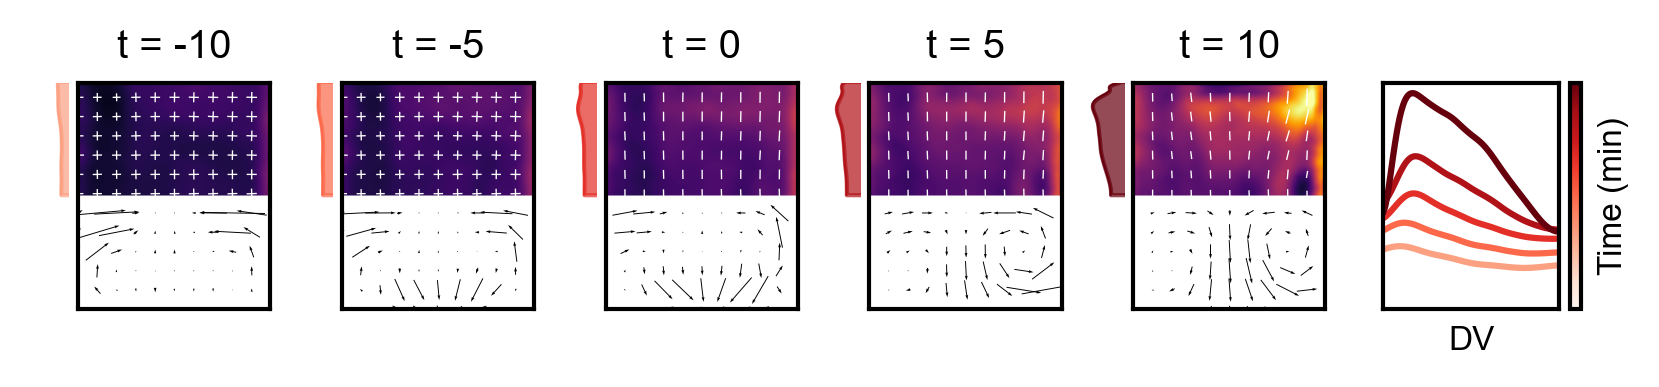

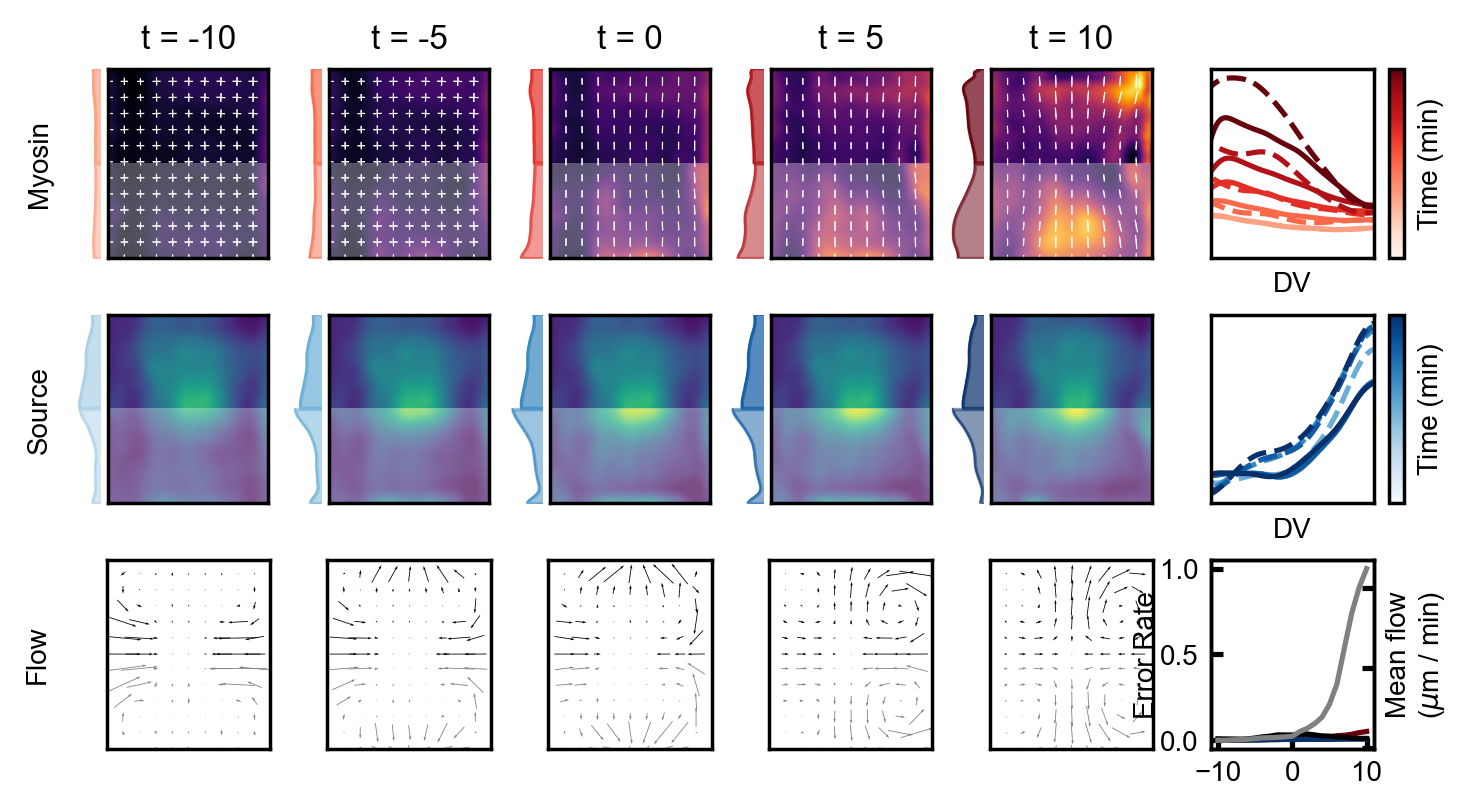

In [4]:
from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.plot_utils import *

#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 10
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]

#Using a flow field interpolator in the loop instead of a neural network
v_int = interp1d(t0, v0, axis=0, fill_value='extrapolate')
v_model = lambda t, y: v_int(t)

y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])

model1 = ClosedFlyLoop(v_model, ap_mode='replicate').fit(y0)
m1, s1, v1 = model1.integrate(y0, t0)
sqh_vel_plot(m1, v1, t0, dt=5)
comparison_plot(t0,
                ('Myosin', m1, m0),
                ('Source', s1, s0),
                ('Flow', v1, v0),
                dt=5)